In [62]:
import scanpy
import matplotlib.pyplot as plt
import seaborn as sns
import magic
from sklearn import decomposition
import numpy as np
import pickle
import scprep

In [2]:
adata_beta = scanpy.read_h5ad('../data/beta_run_2.h5ad')

In [3]:
usamples = ["WT", "OB/OB", "WT", "HFD"]
lut = {usamples[i]: plt.get_cmap("tab10")(i) for i in range(4)}

In [4]:
sns.set_style('white')

In [5]:
colors = list(sns.color_palette('Set1', n_colors=3)) + ['lightgray'] + list(sns.color_palette('Set2', n_colors=7).as_hex())
at_cmap = dict(zip(adata_beta.obs['AT_committment'].sort_values().unique(), colors)) 

## Get embedding

In [6]:
data_magic_op = magic.MAGIC(random_state=42, t=10)
data_magic = data_magic_op.fit_transform(adata_beta.to_df())

combined_pc_op = decomposition.PCA(n_components=10, random_state=42)
combined_magic_pc = combined_pc_op.fit_transform(data_magic)
combined_magic_pc_norm = combined_magic_pc / np.std(combined_magic_pc[:, 0])

Calculating MAGIC...
  Running MAGIC on 17336 cells and 16483 genes.
  Calculating graph and diffusion operator...


/gpfs/gibbs/project/krishnaswamy_smita/av622/conda_envs/gspa/lib/python3.8/site-packages/magic/magic.py:425: UserWarning: Input matrix contains unexpressed genes. Please remove them prior to running MAGIC.
  warnings.warn(


    Calculating PCA...
    Calculated PCA in 8.91 seconds.
    Calculating KNN search...
    Calculated KNN search in 123.90 seconds.
    Calculating affinities...
    Calculated affinities in 124.04 seconds.
  Calculated graph and diffusion operator in 257.35 seconds.
  Running MAGIC with `solver='exact'` on 16483-dimensional data may take a long time. Consider denoising specific genes with `genes=<list-like>` or using `solver='approximate'`.
  Calculating imputation...
  Calculated imputation in 177.62 seconds.
Calculated MAGIC in 435.70 seconds.


In [26]:
with open ('results/combined_magic_pc_op.pkl', 'wb') as f:
    pickle.dump(combined_pc_op, f)

## Visualize sample ids and genes

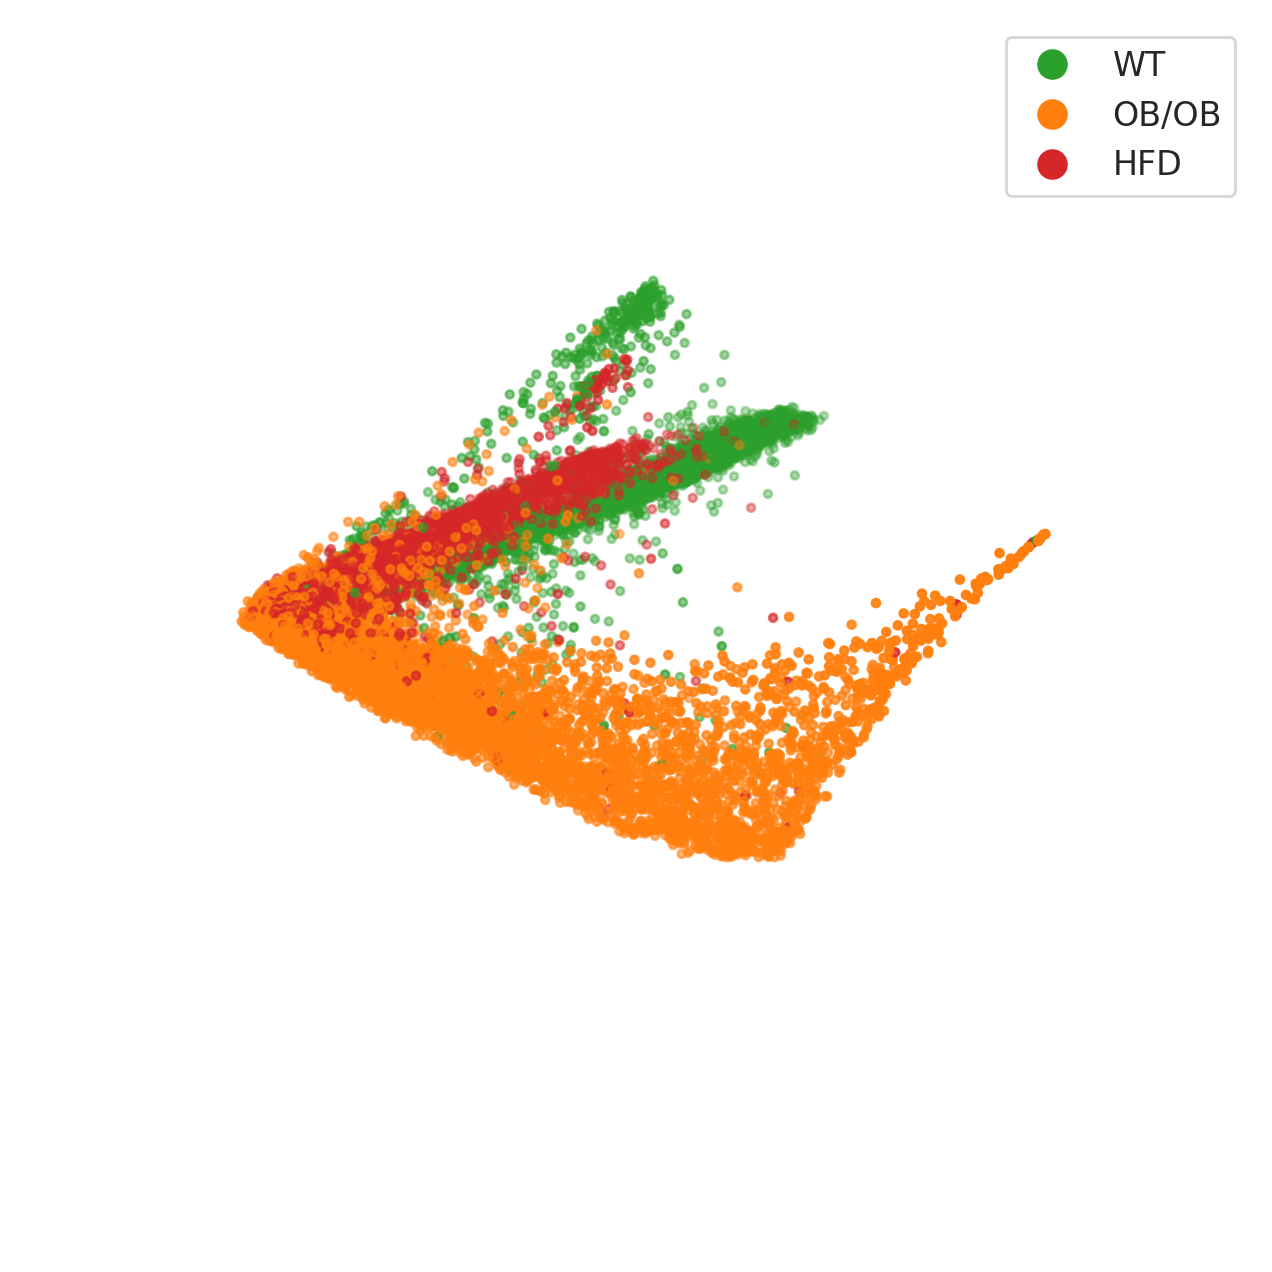

In [67]:
fig = plt.figure(figsize=(10,8), dpi=200)
ax = fig.add_subplot(111, projection='3d')
scprep.plot.scatter3d(combined_magic_pc_norm, c=adata_beta.obs.samples, cmap=lut, ax=ax, ticks=None, s=8, azim=-30,elev=40)
ax.axis('off')
fig.savefig(f'figures/beta_cells.png', dpi=200)

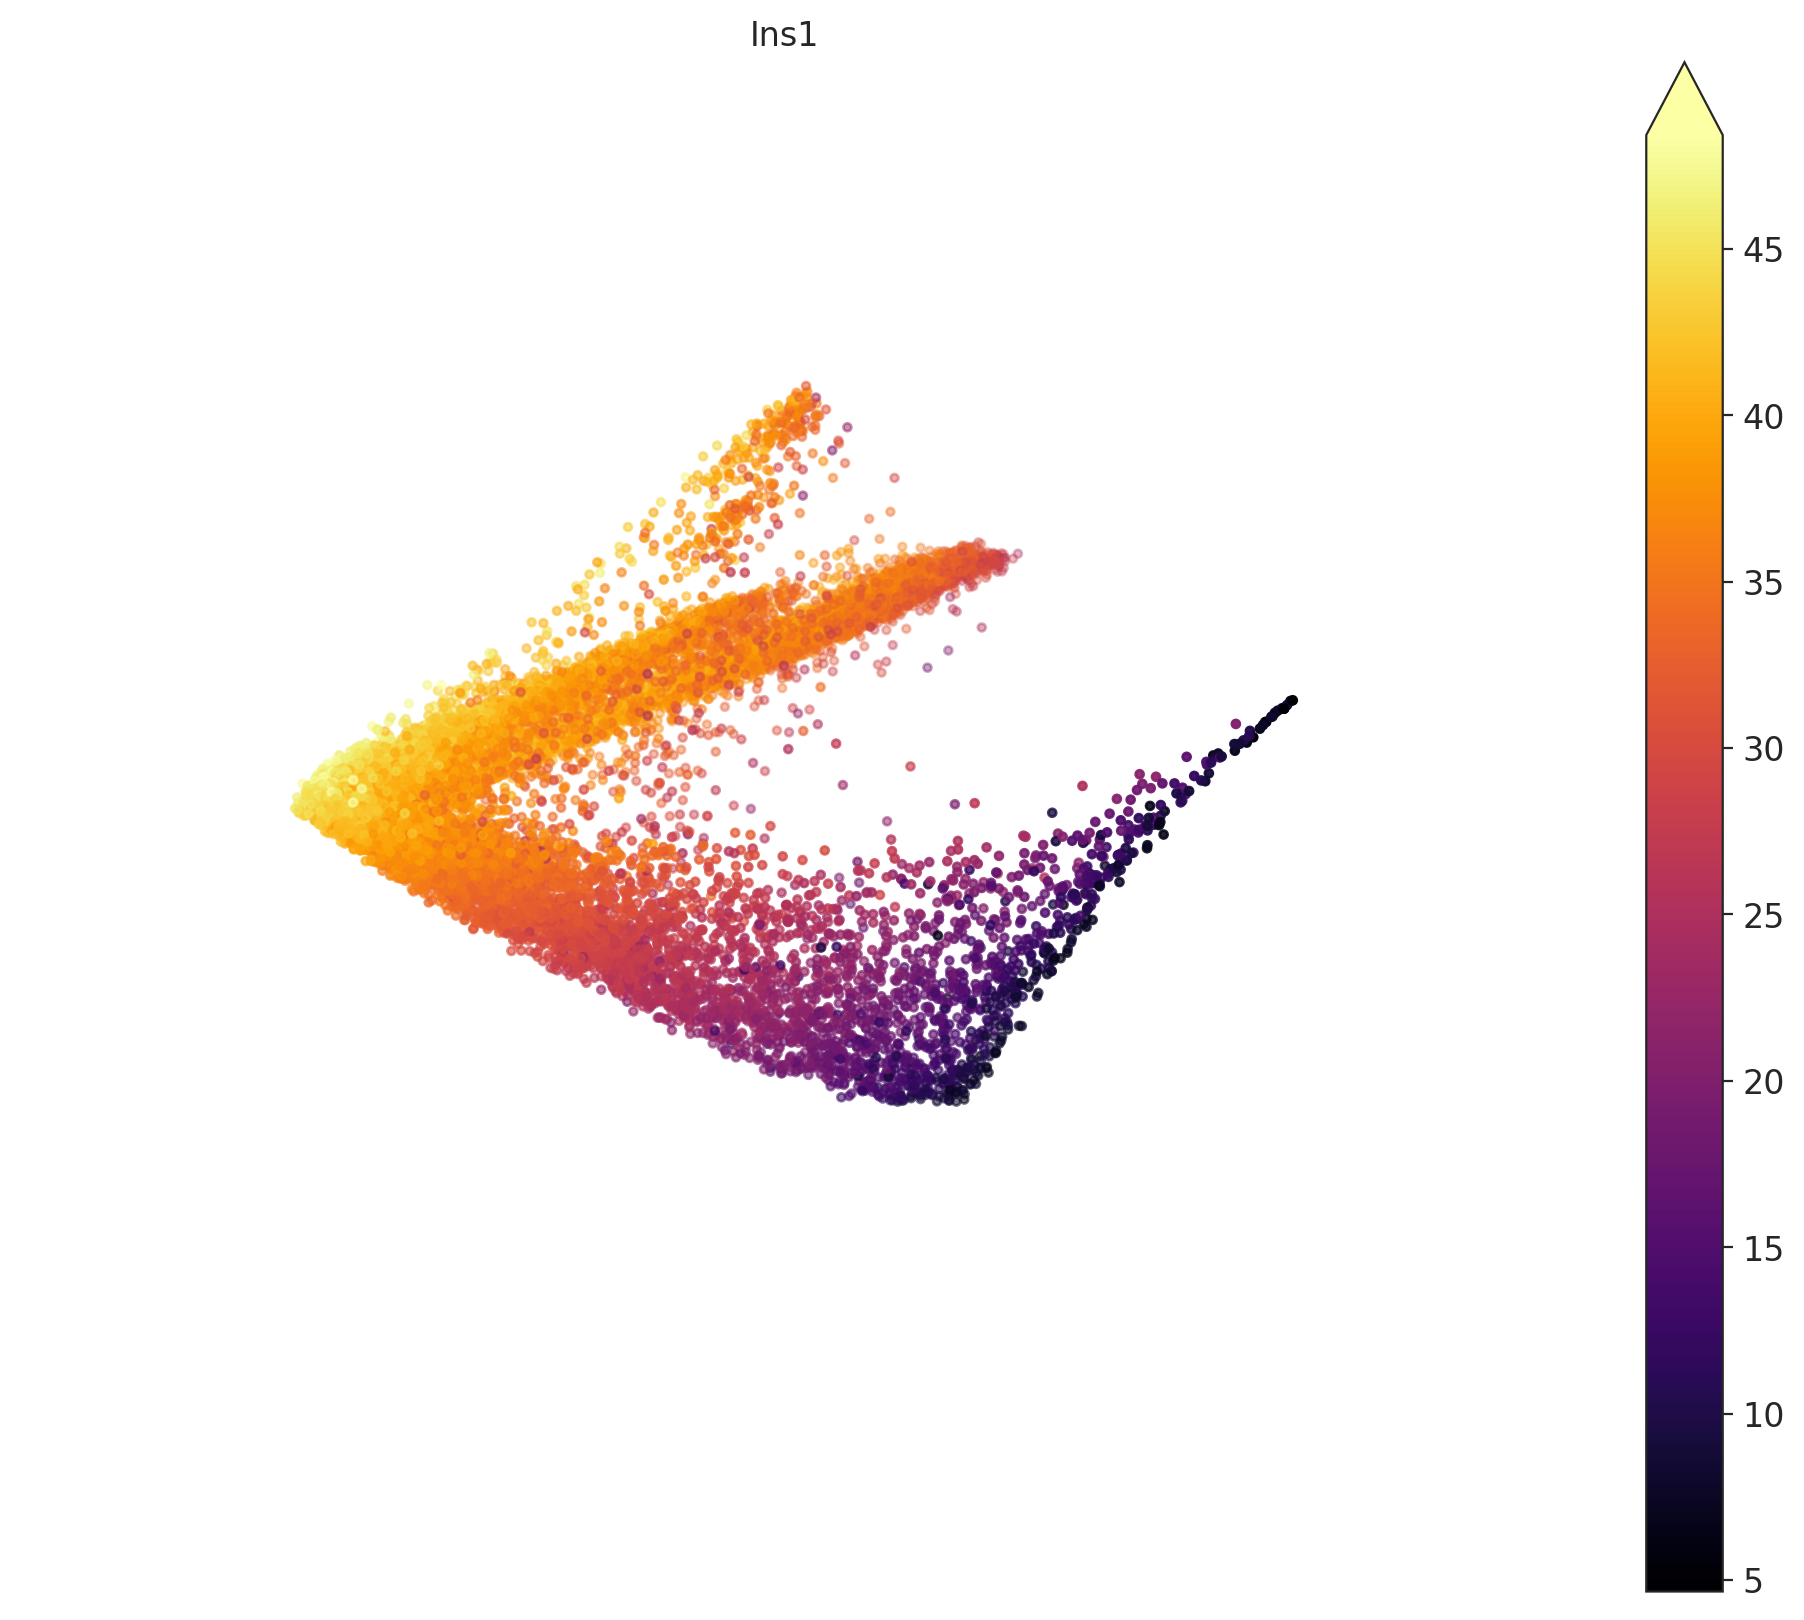

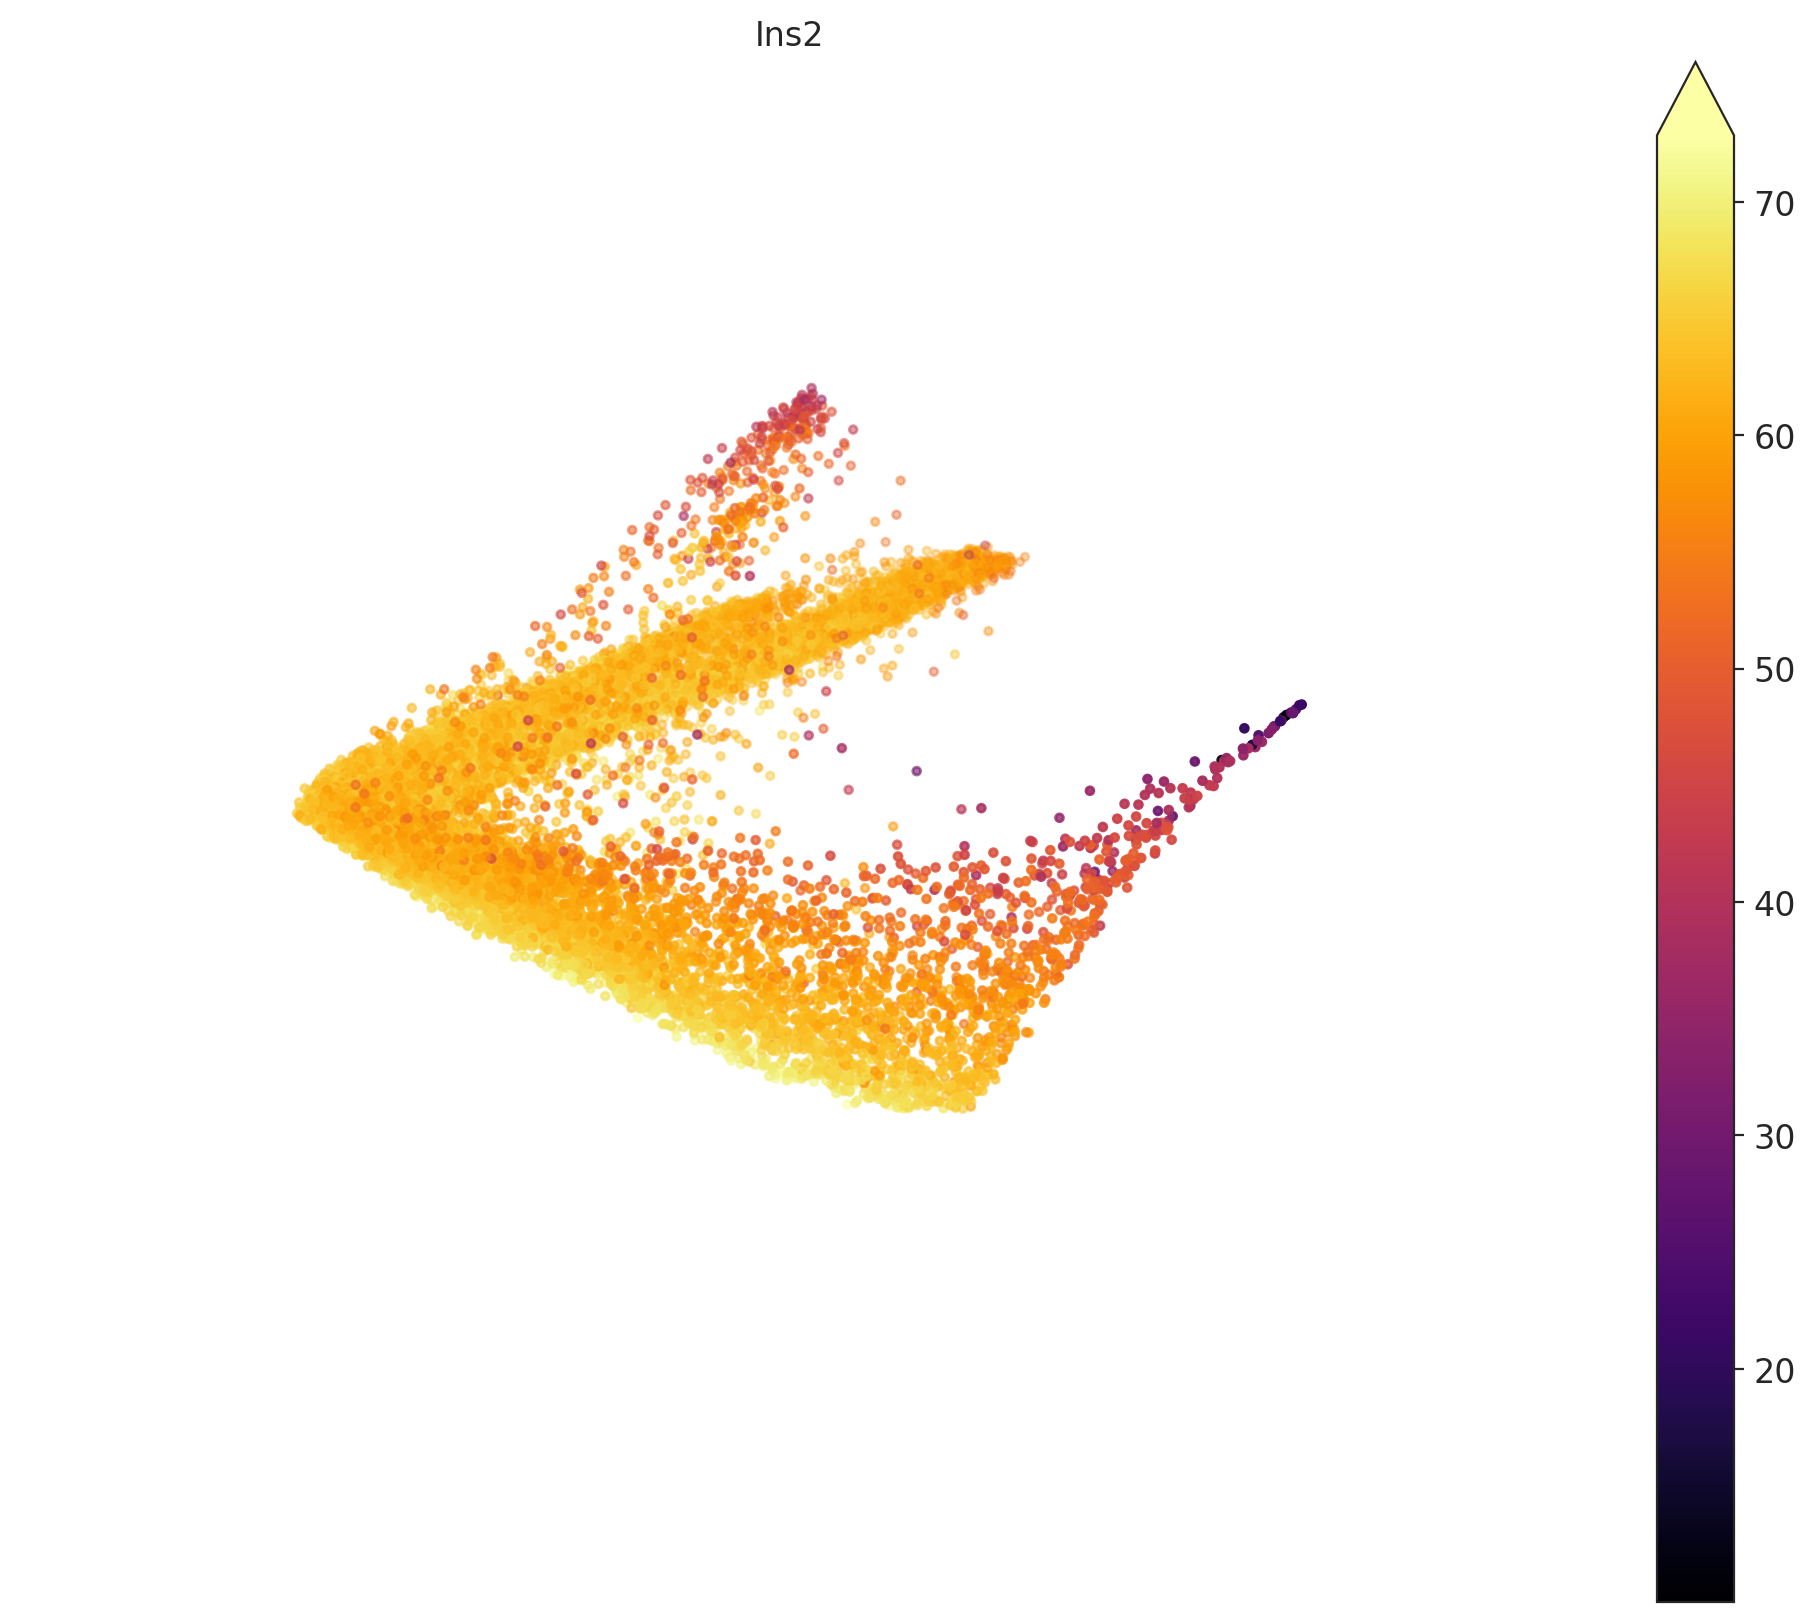

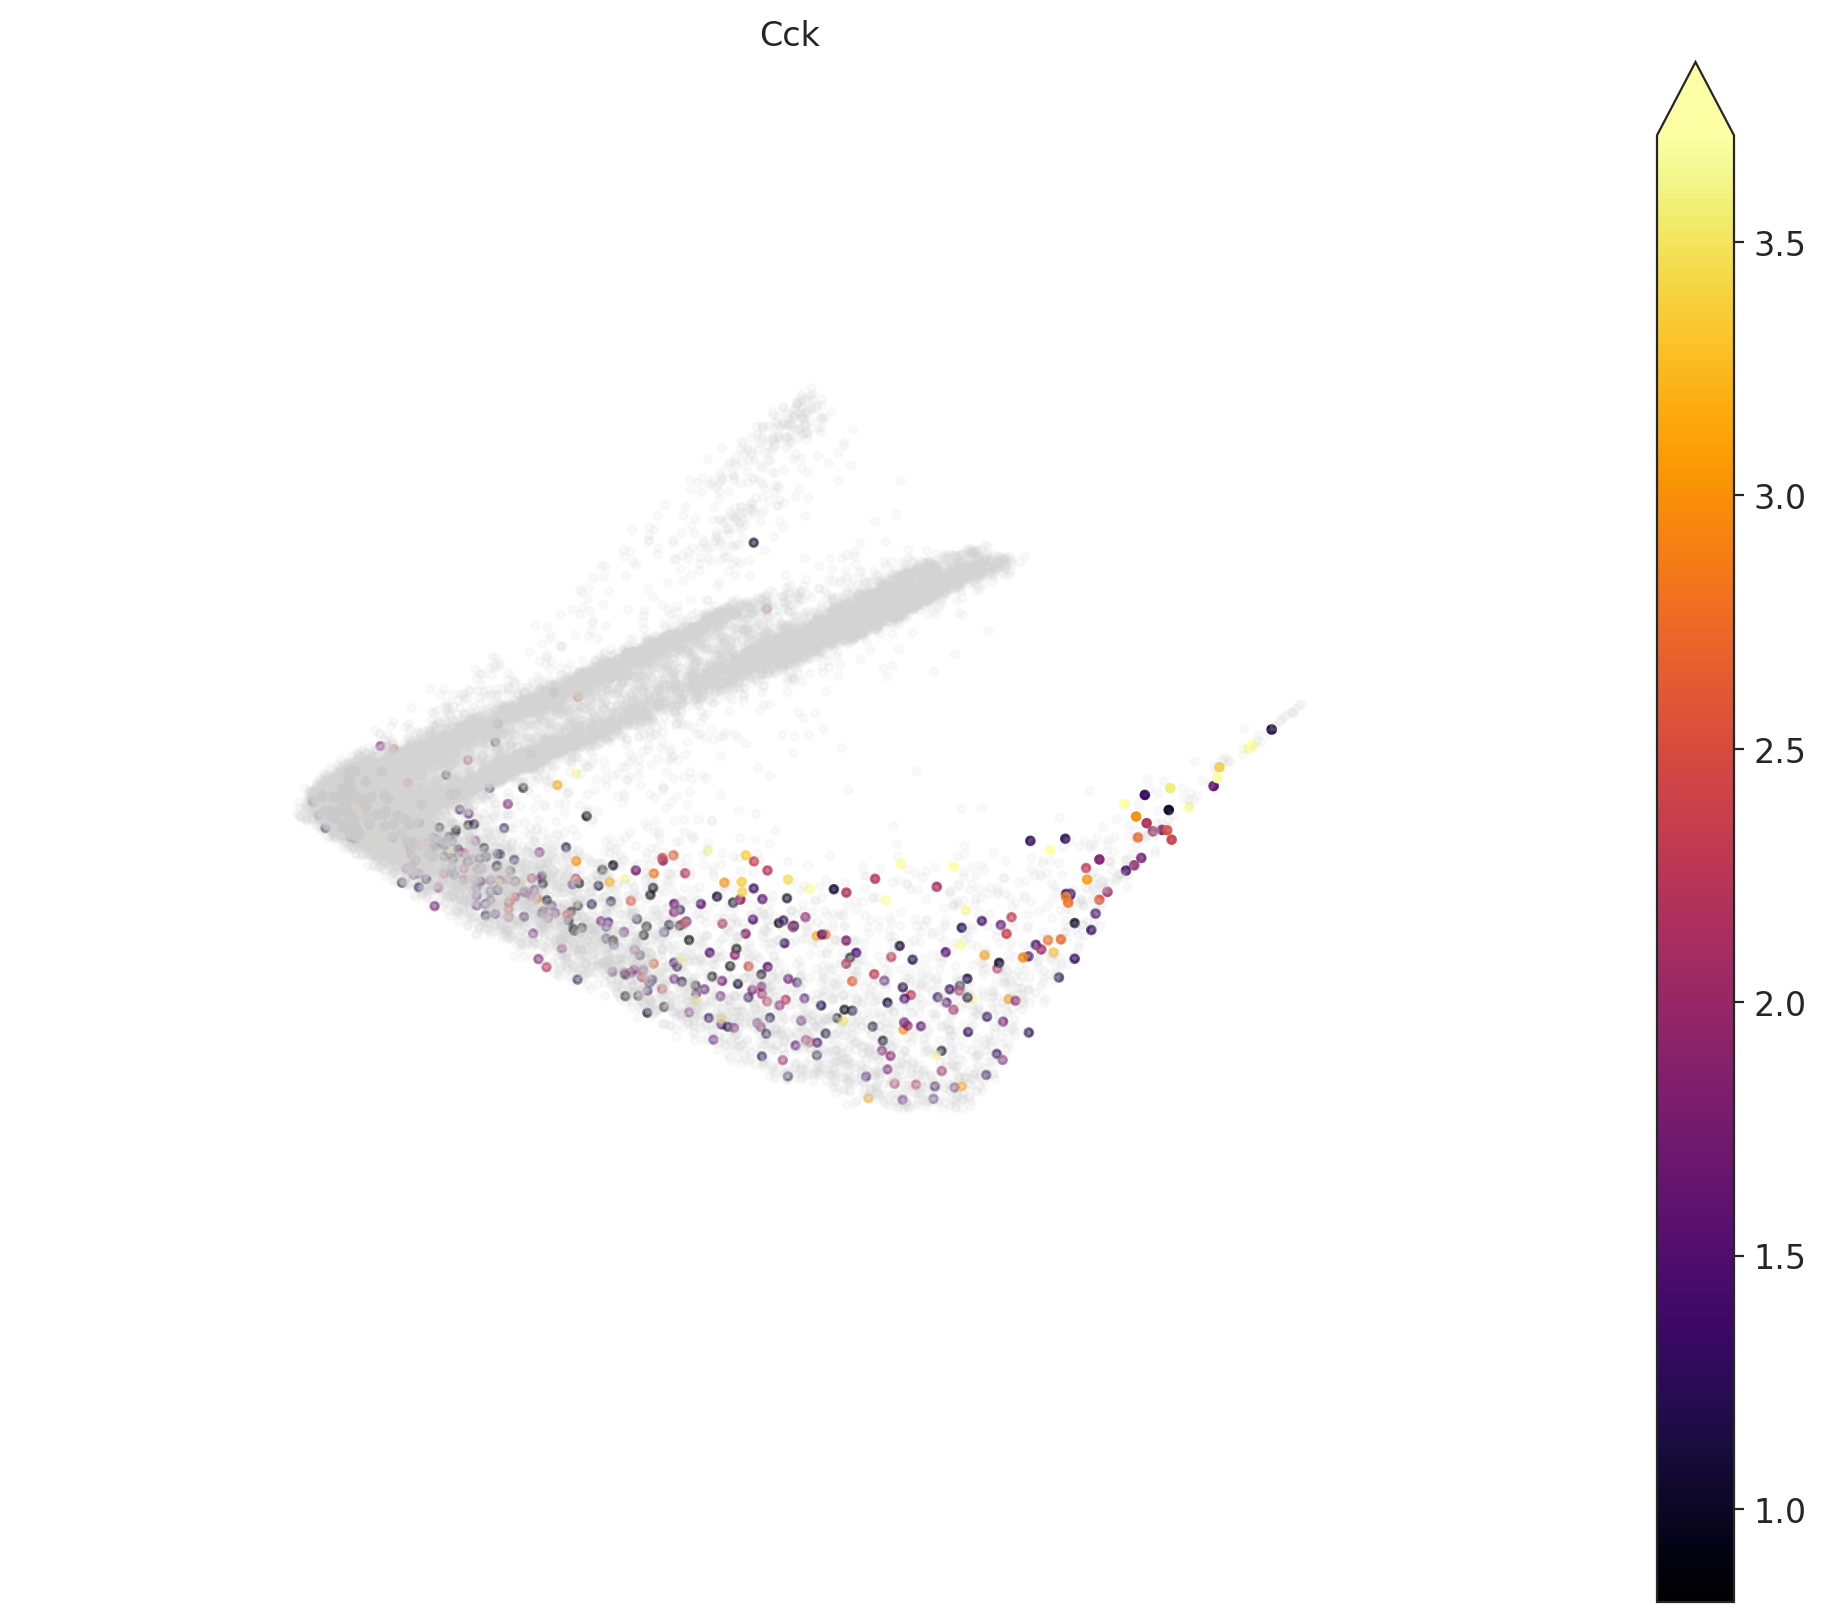

In [63]:
for gene in ['Ins1', 'Ins2', 'Cck']:
    fig = plt.figure(figsize=(10,8), dpi=200)
    ax = fig.add_subplot(projection='3d')
    scprep.plot.scatter3d(combined_magic_pc_norm, alpha=0.1, c='lightgray', ax=ax, ticks=None, s=8, azim=-30,elev=40,
                          mask=adata_beta[:, adata_beta.var['names'] == gene].to_df().values.flatten() == 0)
    scprep.plot.scatter3d(combined_magic_pc_norm, c=adata_beta[:, adata_beta.var['names'] == gene].to_df().values.flatten(),ax=ax, 
                          ticks=None, s=8, azim=-30,elev=40,
                          mask=adata_beta[:, adata_beta.var['names'] == gene].to_df().values.flatten() > 0.0, 
                          vmax=np.percentile(adata_beta[:, adata_beta.var['names'] == gene].to_df().values.flatten(), 99.9))
    plt.tight_layout()
    ax.axis('off')
    plt.title(gene)
    fig.savefig(f'figures/{gene}.png', dpi=200)

## Get trajectories to OB/OB 2

In [28]:
combined_magic_pc_norm = np.load('data/combined_magic_pca_tnet_input_5_tp.npz')['pca']
TrajectoryNet_timepoints = np.load('data/combined_magic_pca_tnet_input_5_tp.npz')['sample_labels']

In [59]:
adata_beta.obs['TrajectoryNet_timepoints'] = TrajectoryNet_timepoints
adata_beta.obsm['combined_magic_pc'] = combined_magic_pc
adata_beta.obsm['combined_magic_pc_norm'] = combined_magic_pc_norm

In [46]:
adata_beta_last_timepoint = adata_beta[adata_beta.obs['TrajectoryNet_timepoints'] == 4]

In [86]:
backwards_trajectories = np.load('results/islet_run_combined_magic_pca_5_tp_run1_growth/backward_trajectories.npy') 
backwards_trajectories_to_obob2 = backwards_trajectories[:, adata_beta_last_timepoint.obs['AT_committment'] == 'OB/OB AT 2', :]
np.save('results/islet_run_combined_magic_pca_5_tp_run1_growth/backward_trajectories_OBOB_AT2.npy',
        backwards_trajectories_to_obob2)

In [84]:
# repeat for run 2 
backwards_trajectories = np.load('results/islet_run_combined_magic_pca_5_tp_run2_growth/backward_trajectories.npy') 
backwards_trajectories_to_obob2 = backwards_trajectories[:, adata_beta_last_timepoint.obs['AT_committment'] == 'OB/OB AT 2', :]
np.save('results/islet_run_combined_magic_pca_5_tp_run2_growth/backward_trajectories_OBOB_AT2.npy',
        backwards_trajectories_to_obob2)

In [ ]:
adata_beta.write('../data/beta_run_2.h5ad')

## Visualize trajectories

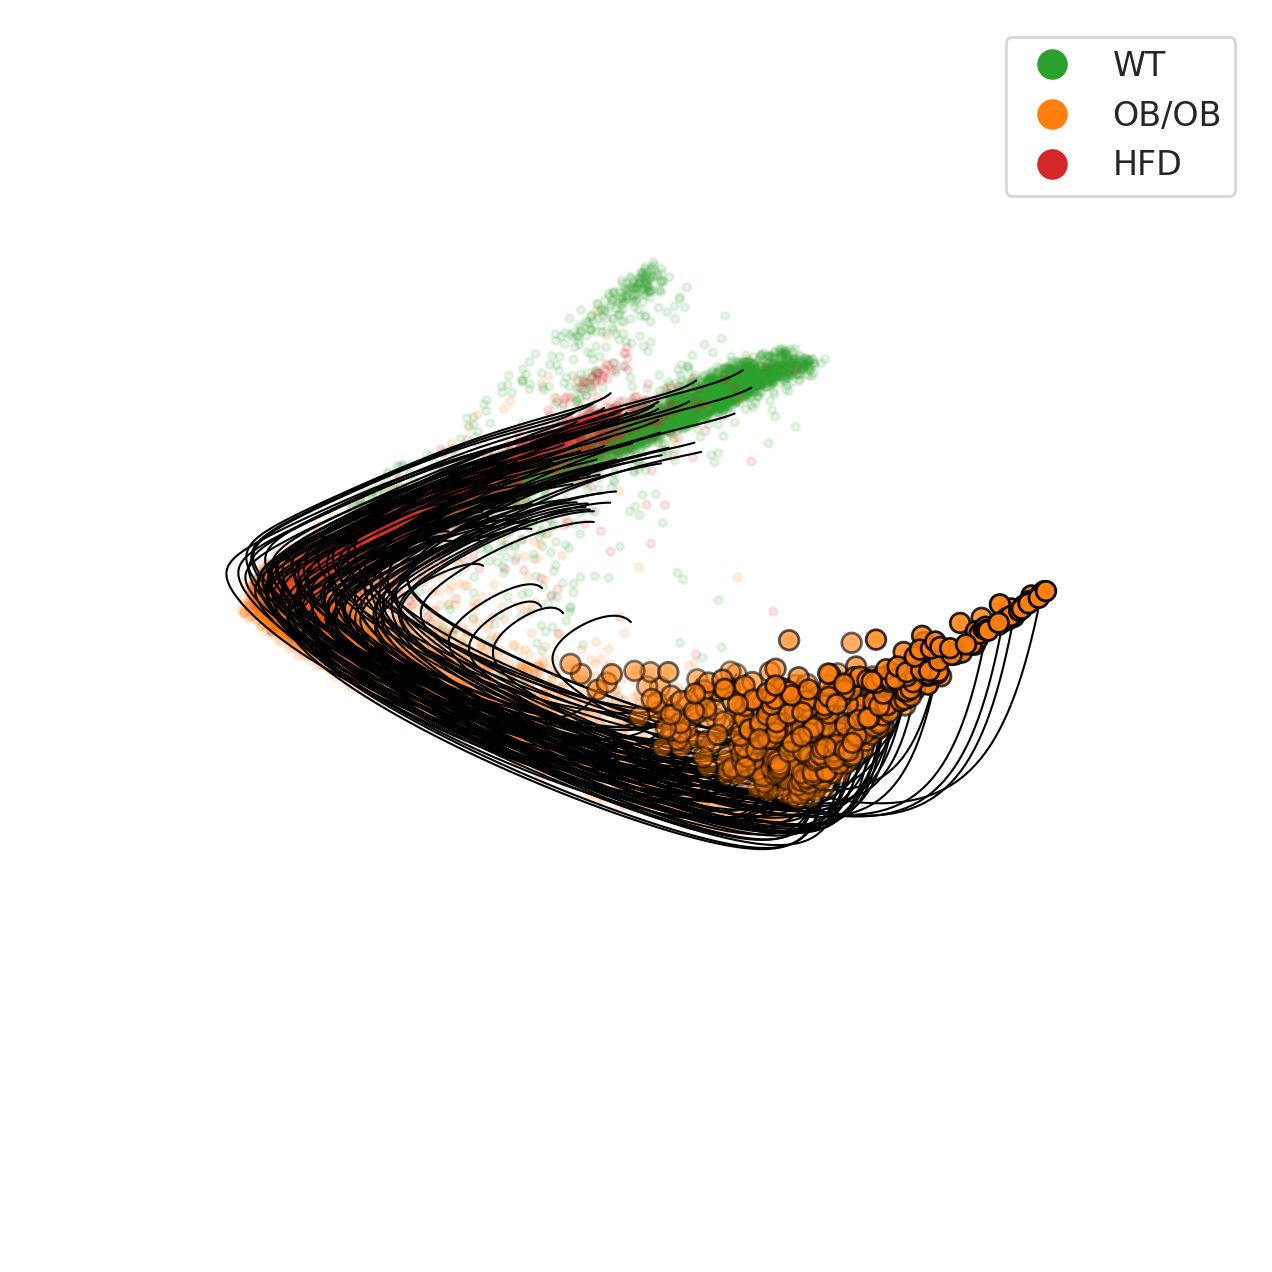

In [87]:
numlines = 100
fig = plt.figure(figsize=(10,8), dpi=200)
ax = fig.add_subplot(111, projection='3d')

for i in range(numlines):
    ax.plot(backwards_trajectories_to_obob2[:, i, 0],
            backwards_trajectories_to_obob2[:, i, 1], 
            backwards_trajectories_to_obob2[:, i, 2], c='k', linewidth=0.75)

scprep.plot.scatter3d(combined_magic_pc_norm, c=adata_beta.obs.samples, cmap=lut, ax=ax, s=8, alpha=0.1)
scprep.plot.scatter3d(backwards_trajectories_to_obob2[0, :, :],
                      color=lut['OB/OB'], edgecolor='k', ax=ax, s=50, zorder=20, azim=-30,elev=50)
ax.axis('off')

fig.savefig(f'figures/OB_OB_AT_2_cellular_trajectories.png', dpi=200)